#### Download


In [ ]:
!pip install adblockparser
!pip install beautifulsoup4
!pip install virustotal-python
!pip install tldextract
!pip install xlsxwriter
!pip install python-whois
!pip install graphviz

#### Import

In [ ]:
import pandas as pd
import numpy as np
import whois
import os
import json
import math
import ast 
import sqlite3
import requests
import time
import tldextract
import xlsxwriter
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from adblockparser import AdblockRules
from virustotal_python import Virustotal
from pprint import pprint

#### Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### EasyList & EasyPrivacyList
- update the EasyList and EasyPrivacyList file paths

`CheckTrackingReq(rules, url, top_level_url, resource_type)`

In [ ]:
# Description: append the filter rules list
# input: filename = file containing easylist and easyprivacylist 
# return: Adblock rules object
def getRules(filename):
    df = pd.read_excel(filename)
    rules = []
    for i in df.index:
        rules.append(df['url'][i])
    Rules = AdblockRules(rules)
    return Rules

# Description: setting predefined rules
easylist = getRules('/content/EasyPrivacyList.xlsx')
easyPrivacylist = getRules('/content/easyList.xlsx')

# Description: extract domain from given url
# input: url = url for which domain is needed
# return: domain
def getDomain(url):
    ext = tldextract.extract(url)
    return ext.domain+"."+ext.suffix

# Description: check if its thirparty request
# input: url = url 
# input: top_level_url = top_level_url 
# return: returns True if its thirdparty request otherwise false
def isThirdPartyReq(url, top_level_url):
    d_url = getDomain(url)
    d_top_level_url = getDomain(top_level_url)
    if d_url == d_top_level_url:
        return False
    else:
        return True

# Description: check if the request is tracking or non-tracking
# input: rules = Adblock rules object 
# input: url = url 
# input: top_level_url = top_level_url 
# input: resource_type = resource_type 
# return: returns True if it has tracking status otherwise false
def CheckTrackingReq(rules, url, top_level_url, resource_type):
    return int(rules.should_block(url, { resource_type: resource_type, 'domain' : getDomain(url), 'third-party': isThirdPartyReq(url, top_level_url) }))

#### Check Ancestor Nodes for Tracking Behavior
`CheckAncestoralNodes(df, row.call_stack)`

`callstack` -> `stack` & `type`='Script' -> `callframes` & `parent`

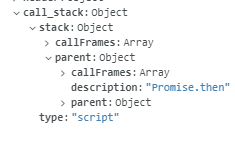

In [ ]:
# Description: Search the tracking status for each unique script url's in the stack
# input: dataset = complete http_req table with easylist and easyprivacylist flags
# input: callstack = call stack object as shown above
# return: it returns 1 if any ancestoral node has tracking status otherwise 0
def CheckAncestoralNodes(dataset,callstack):
  # handling non-script type
  if callstack['type'] != 'script': return None
  # unique scripts in the stack
  unique_scripts = []
  # recursively insert unique scripts in the stack
  rec_stack_checker(callstack["stack"], unique_scripts)
  # check the tracking status of the unique scripts
  return check_script_url(dataset, unique_scripts)

# Description: Search the tracking status for each unique script url's in the stack
# input: dataset = complete http_req table with easylist and easyprivacylist flags
# input: unique_scripts = unique scripts in the given stack
# return: it returns 1 if any unique script url has tracking status otherwise 0
def check_script_url(dataset, unique_scripts):
  for i in range(len(unique_scripts)):
    for j in dataset.index:
      if dataset['http_req'][j] == unique_scripts[i]: 
        if dataset['easylistflag'][j] == 1 or dataset['easyprivacylistflag'][j] == 1: return 1
  return 0


# Description: it appends the unique script url's recursively
# input: stack = stack object as shown in the image above
# input: unique_scripts = unique scripts in the given stack
# return: nothing
def rec_stack_checker(stack, unique_scripts):
  # append unique script_url's 
  for item in stack['callFrames']:
    if item['url'] not in unique_scripts:
      unique_scripts.append(item['url'])
  # if parent object doen't exist return (base-case)
  if 'parent' not in stack.keys(): return
  # else send a recursive call for this
  else: rec_stack_checker(stack['parent'], unique_scripts)

#### Dependency Graph Plotter

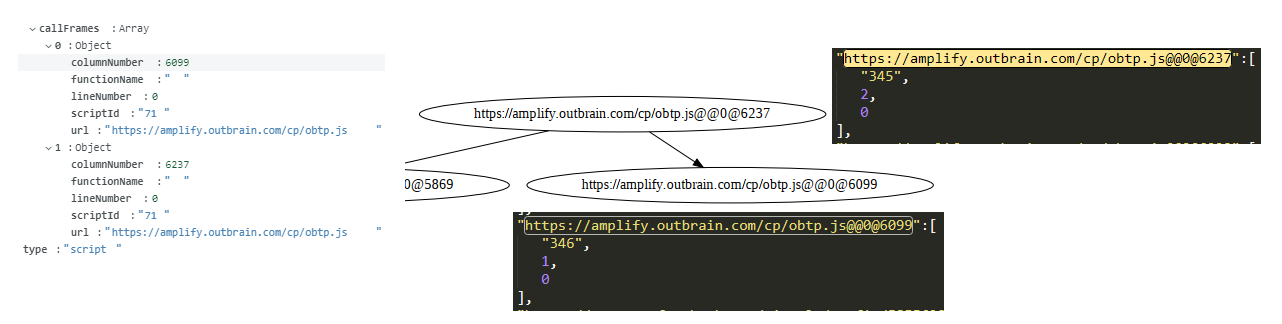

In [ ]:
def dependency_graph(dataset):
  # syntax: {"url+functionName+lineNumber+columnNumber": ["label", count]}
  # count +1 for tracking & -1 for non-tracking
  unique_nodes = {}
  unique_edges = []
  label = [1]
  plot = Digraph(comment='The Round Table')
  for i in dataset.index:
    # handling non-script type
    if dataset['call_stack'][i]['type'] != 'script': pass
    else:
      # recursively add uniques nodes in the graph
      # if its tracking http call then update the tracking count of all scripts in that stack
      if dataset['easylistflag'][i] == 1 or dataset['easyprivacylistflag'][i] == 1 or dataset['ancestorflag'][i] == 1:
        rec_stack_nodes_adder(dataset['call_stack'][i]['stack'], unique_nodes, label, 1, plot)
      # if its non-tracking http call then update the non-tracking count of all scripts in that stack
      else:
        rec_stack_nodes_adder(dataset['call_stack'][i]['stack'], unique_nodes, label, 0, plot)
      # recursively add edges in the graph
      rec_plot_edges(dataset['call_stack'][i]['stack'], unique_nodes, unique_edges, plot, None)
  print(unique_nodes)
  # rendering the plot
  plot.render('/test-output/dp_graph.gv', view=True)
  #print(plot.source)

# Description: it creates edges in the plot recursively
# input: stack = stack object as shown in the image above
# input: unique_nodes = unique nodes in the given website trace 
# input: unique_edges = unique edges in the given website trace 
# input: plot = dot plot object 
# input: prev = It is set when we are jumping from base to parent and initially not set
# return: nothing
def rec_plot_edges(stack, unique_nodes, unique_edges, plot, prev):
  for i in range(len(stack['callFrames'])-1):
    if prev is not None:
     # if edge is not already created only then create that edge (prev-condition)
     if (unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0]
              , prev) not in unique_edges:
              # create edge
              plot.edge(unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0]
              , prev)
              # append edge in the list
              unique_edges.append((unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0]
              , prev))
     # if edge is not already created only then create that edge (base-condition)
    if (unique_nodes[stack['callFrames'][i+1]['url']+"@"+stack['callFrames'][i+1]['functionName']+"@"+str(stack['callFrames'][i+1]['lineNumber'])+"@"+str(stack['callFrames'][i+1]['columnNumber'])][0]
              , unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0]) not in unique_edges:
              # create edge
              plot.edge(unique_nodes[stack['callFrames'][i+1]['url']+"@"+stack['callFrames'][i+1]['functionName']+"@"+str(stack['callFrames'][i+1]['lineNumber'])+"@"+str(stack['callFrames'][i+1]['columnNumber'])][0]
              , unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0])
              # append edge in the list
              unique_edges.append((unique_nodes[stack['callFrames'][i+1]['url']+"@"+stack['callFrames'][i+1]['functionName']+"@"+str(stack['callFrames'][i+1]['lineNumber'])+"@"+str(stack['callFrames'][i+1]['columnNumber'])][0]
              , unique_nodes[stack['callFrames'][i]['url']+"@"+stack['callFrames'][i]['functionName']+"@"+str(stack['callFrames'][i]['lineNumber'])+"@"+str(stack['callFrames'][i]['columnNumber'])][0]))
  # if parent object doen't exist return (base-case)
  if 'parent' not in stack.keys(): return
  # in case where base is empty but parent exists
  elif len(stack['callFrames']) == 0: rec_plot_edges(stack['parent'], unique_nodes, unique_edges, plot, None)
  # else send recursive call for parent and set the prev
  else: rec_plot_edges(stack['parent'], 
                          unique_nodes, unique_edges, plot, unique_nodes[stack['callFrames'][len(stack['callFrames'])-1]['url']+"@"+stack['callFrames'][len(stack['callFrames'])-1]['functionName']+"@"+
                                                                  str(stack['callFrames'][len(stack['callFrames'])-1]['lineNumber'])+"@"+str(stack['callFrames'][len(stack['callFrames'])-1]['columnNumber'])][0])


# Description: it appends the unique node url+functionname+linenumber+columnnumber recursively
# input: stack = stack object as shown in the image above
# input: unique_nodes = unique nodes in the given stack 
# input: label = its the label for the uique node
# input: plot = dot plot object 
# return: nothing
def rec_stack_nodes_adder(stack, unique_nodes, label, trackingflag, plot):
  # append unique script_url's 
  for item in stack['callFrames']:
    if item['url']+"@"+item['functionName']+"@"+str(item['lineNumber'])+"@"+str(item['columnNumber']) not in unique_nodes.keys():
      unique_nodes[item['url']+"@"+item['functionName']+"@"+str(item['lineNumber'])+"@"+str(item['columnNumber'])] =  [str(label[0]), 0, 0]
      plot.node( str(label[0]), item['url']+"@"+item['functionName']+"@"+str(item['lineNumber'])+"@"+str(item['columnNumber']))
      label[0] += 1
    # if its tracking call then +1 the tracking count for that node
    if trackingflag == 1:
      unique_nodes[item['url']+"@"+item['functionName']+"@"+str(item['lineNumber'])+"@"+str(item['columnNumber'])][1] += 1
    # elsw if its non-tracking call then +1 the non-tracking count for that node
    else:
      unique_nodes[item['url']+"@"+item['functionName']+"@"+str(item['lineNumber'])+"@"+str(item['columnNumber'])][2] += 1
  # if parent object doen't exist return (base-case)
  if 'parent' not in stack.keys(): return
  # else send a recursive call for this
  else: rec_stack_nodes_adder(stack['parent'], unique_nodes, label, trackingflag, plot)

#### Intilization
Pass complete dataset and it will add columns for:
- EasyList
- EasyPrivacyList
- AncestorFlag

All of these are boolean(0/1) flags where:
- 0 means non-tracking status
- 1 means tracking status

`df = intilization('/output.json')`

In [ ]:
# Description: Handles all initilization process like EasyList, EasyPrivacyList, Ancestor Flags
# input: JSONfile_path = file containg the http request data 
# return: returns updated dataframe
def intilization(JSONfile_path):
  # reading file as dataframe
  dataset = pd.read_json(JSONfile_path, lines=True)
  with open("logs.txt","a") as log: log.write("\n----------[intilization] JSON reading complete------------"); log.close()
  # adding easylistflag column
  dataset['easylistflag'] = dataset.apply(lambda row: CheckTrackingReq(easylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)
  with open("logs.txt","a") as log: log.write("\n----------[intilization] easylistflag column added------------"); log.close()
  # adding easyprivacylistflag column
  dataset['easyprivacylistflag'] = dataset.apply(lambda row: CheckTrackingReq(easyPrivacylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)
  with open("logs.txt","a") as log: log.write("\n----------[intilization] EasyPrivacylistflag column added------------"); log.close()

  # extracting unique top_level_url
  sites = dataset['top_level_url'].unique()
  # returning dataset
  retDataset = pd.DataFrame()
  # adding ancestoral flag
  # extracting site by site data
  for site in sites:
    df = dataset.loc[dataset['top_level_url'] == site]
    df["ancestorflag"] = df.apply(lambda row: CheckAncestoralNodes(df, row.call_stack), axis = 1)
    retDataset = retDataset.append(df)
  with open("logs.txt","a") as log: log.write("\n----------[intilization] AncestoralFlag column added------------"); log.close()
  
  # return dataset
  return retDataset

#### Distribution Graph Plotter
> Xvfb :99 &
export DISPLAY=:99


`DistGraphPlotter(dataset, 'domain')`



In [ ]:
# Description: Creates distribution plot
# input: dataset = file containing complete columns EL, EPL, AF
# input: dickey = 'domain', 'hostname', 'script'
# return: nothing just creates plot
def DistGraphPlotter(dataset, dickey):
  # dictionary for storing key value pairs
  # key as specified in input parameter
  # value is a list = [tracking_calls, non-tracking_calls]
  dic={}
  # iterating complete dataset
  for i in dataset.index:
    # handling non-script type
    if dataset['call_stack'][i]['type'] != 'script': pass
    else:
      # handling input key specification
      if dickey == 'domain':
         key = getDomain(dataset['http_req'][i])
      elif dickey == 'hostname':
        pass
      elif dickey == 'script':
        pass

      # inserting dickey as a new pair
      if key not in dic.keys():
        if dataset['easylistflag'][i] == 1 or dataset['easyprivacylistflag'][i] == 1 or dataset['ancestorflag'][i] == 1:
          dic[key] = [1, 0]
        else:
          dic[key] = [0, 1]
      # updating dickey if it exits already
      else:
        if dataset['easylistflag'][i] == 1 or dataset['easyprivacylistflag'][i] == 1 or dataset['ancestorflag'][i] == 1:
          dic[key][0] += 1
        else:
          dic[key][1] += 1
      with open("logs.txt","a") as log: logs.write("\n----------[DistGraphPlotter] dictionary created------------"); log.close()
      # creating dataframe for dist graph plotting
  data = []
  for i in dic.keys():
      # calculating ratio i.e log10 (tracking_calls/non-tracking_calls)
      data.append((i, dic[i][0], dic[i][1], math.log((dic[i][0]+0.001)/(dic[i][1]+0.001), 10)))
  df = pd.DataFrame(
          data,
          columns=[dickey, "tracking_calls", "non-tracking_calls", "log10 (tracking_calls/non-tracking_calls)"])
  with open("logs.txt","a") as log: logs.write("\n----------[DistGraphPlotter] dictionary to dataframe conversion completed------------"); log.close()
  # creating distplot using sns
  sns.displot(data=df, x="log10 (tracking_calls/non-tracking_calls)", kde=True,stat="probability").savefig("Domain.png")

### DataFrame to Excel


`df_to_excel(dataset, 'test.xlsx')`


In [ ]:
# Description: Converts dataframe to excel file
# input: dataset = dataframe to be converted
# input: filename = name of the csv file 'test.xlsx'
# return: nothing
def df_to_excel(dataset, filename):
  writer = pd.ExcelWriter(filename, engine='xlsxwriter',options={'strings_to_urls': False})
  dataset.to_excel(writer)
  writer.close()

## Main Testing


#### Testing Graph Plotter

In [ ]:
df=intilization('/content/request.json')

In [ ]:
df

In [ ]:
DistGraphPlotter(df, 'domain')

In [ ]:
dataset = pd.read_json(r'/output.json', lines=True)
#dataset
dataset['easylistflag'] = dataset.apply(lambda row: CheckTrackingReq(easylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)
dataset['easyprivacylistflag'] = dataset.apply(lambda row: CheckTrackingReq(easyPrivacylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)
dataset

In [ ]:
dataset

In [ ]:
df = dataset
dataset["ancestorflag"] = dataset.apply(lambda row: CheckAncestoralNodes(df, row.call_stack), axis = 1)

In [ ]:
writer = pd.ExcelWriter(r'output.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
df.to_excel(writer)
writer.close()

In [ ]:
dependency_graph(dataset)

#### Testing Domain Graph

In [ ]:
dataset = pd.read_json(r'/content/request.json', lines=True)
dataset

In [ ]:
sites = cmpdataset['top_level_url'].unique()

In [ ]:
sites

In [ ]:
df = cmpdataset.loc[cmpdataset['top_level_url'] == 'https://www.express.co.uk/']
df

In [ ]:
cmpdataset['easylistflag'] = cmpdataset.apply(lambda row: CheckTrackingReq(easylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)
cmpdataset['easyprivacylistflag'] = cmpdataset.apply(lambda row: CheckTrackingReq(easyPrivacylist, row.http_req,row.top_level_url, row.resource_type), axis = 1)

In [ ]:
cmpdataset

In [ ]:
for site in sites:
  df = cmpdataset.loc[cmpdataset['top_level_url'] == site]
  df["ancestorflag"] = df.apply(lambda row: CheckAncestoralNodes(df, row.call_stack), axis = 1)
  mainDF = mainDF.append(df)

In [ ]:
mainDF=pd.DataFrame()

In [ ]:
dataset=mainDF

In [ ]:
dic={}
for i in dataset.index:
  if dataset['call_stack'][i]['type'] != 'script': pass
  else:
    if getDomain(dataset['http_req'][i]) not in dic.keys():
      if dataset['easylistflag'][i] == 1 or dataset['easyprivacylistflag'][i] == 1 or dataset['ancestorflag'][i] == 1:
        dic[getDomain(dataset['http_req'][i])] = [1, 0]
      else:
        dic[getDomain(dataset['http_req'][i])] = [0, 1]
    else:
      if dataset['easylistflag'][i] == 1 or dataset['easyprivacylistflag'][i] == 1 or dataset['ancestorflag'][i] == 1:
        dic[getDomain(dataset['http_req'][i])][0] += 1
      else:
        dic[getDomain(dataset['http_req'][i])][1] += 1



In [ ]:
data = []
for i in dic.keys():
    data.append((i, dic[i][0], dic[i][1], math.log((dic[i][0]+0.001)/(dic[i][1]+0.001), 10)))
df2 = pd.DataFrame(
         data,
         columns=["Domain", "tracking calls", "benign calls", "ratio"])
df2.to_excel(r'/DomainAnalysis.xlsx')

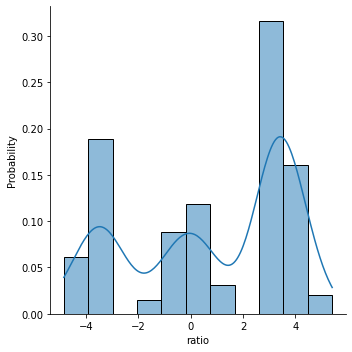

In [ ]:
sns.displot(data=df2, x="ratio", kde=True,stat="probability")

In [ ]:
df=dataset
writer = pd.ExcelWriter(r'Intilization.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
df.to_excel(writer)
writer.close()

In [ ]:
dataset.rename(columns = {'top_level_url':'frame_url'}, inplace = True)
dataset

In [ ]:
def getTopUrl(frame_Url, header):
  if 'Referer' in header.keys():
    return header['Referer']
  else:
    return frame_Url

In [ ]:
dataset['top_level_url'] = dataset.apply(lambda row: getTopUrl(row.frame_url, row.header), axis = 1)

In [ ]:
dataset

In [ ]:
df_to_excel(dataset, 'test.xlsx')

#### Proper Main Driver

In [ ]:
with open("logs.txt","a") as log: log.write("\n----------[Main] Starting------------"); log.close()
with open("logs.txt","a") as log: log.write("\n----------[Main] In intiliazation------------"); log.close()
dataset = intilization('/request.json')
with open("logs.txt","a") as log: log.write("\n----------[Main] Out Intiliazation------------"); log.close()
with open("logs.txt","a") as log: log.write("\n----------[Main] In df_to_excel------------"); log.close()
df_to_excel(dataset, 'PartialAnalysis.xlsx')
with open("logs.txt","a") as log: log.write("\n----------[Main] Out df_to_excel------------"); log.close()
with open("logs.txt","a") as log: log.write("\n----------[Main] In DistGraphPlotter------------"); log.close()
DistGraphPlotter(dataset, 'domain')